# Main analysis file for Vogelstein project

## Cool questions

In [22]:
# Is this between-subject or within-subject?
    # Within-subject. "One subject at two different test sessions"

# How much variance is there between the two sessions this subject underwent? How much signal is there in this noise?

## Get the data

In [98]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=True)  # For clarity

In [8]:
mri1 = nib.load('sub-0025865_ses-1_dwi_aligned.nii')
mri2 = nib.load('sub-0025865_ses-2_dwi_aligned.nii')

In [96]:
mri1_data = mri1.get_data()  # Turn into numpy data
mri2_data = mri2.get_data()

In [93]:
mri1_data.shape

(182, 218, 182, 31)

In [24]:
mri1.shape  # 182x218 image size for 182 slices across 31 sessions

(182, 218, 182, 31)

In [12]:
mri1.shape == mri2.shape

True

In [94]:
hdr = mri1.header  # metadata about the image

In [95]:
print(hdr)  # Show me the money

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 182 218 182  31   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.  1.  1.  1.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : -138.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 90.0
qoffset_y       : 91.0
qoffset_z       : -72.0
srow_x          : [ -1.   0.   0. 

In [46]:
hdr.get_xyzt_units()
# Time is in seconds, size units are in millimeters.

('mm', 'sec')

In [79]:
mri1.affine  # This relates voxel coordinates to real-world coordinates... somehow
# TODO: figure out exactly how affines relate voxel coordinates to real-world coordinates.

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

## Basic visualization

In [103]:
mri1_data.shape  # x, y, z, time

(182, 218, 182, 31)

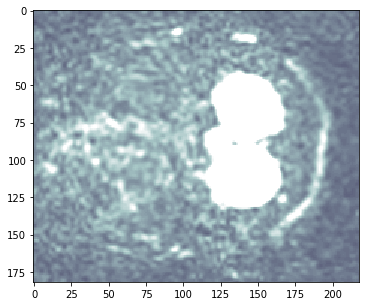

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(mri1_data[:, :, 15, 8], interpolation="nearest",
          cmap='bone', vmin='-30', vmax='45')  # 15th slice is where


## Scale the data

Scale the data (window) to allow easy viewing of the data and plot time=5 and z slice=15 from each session (and explain why you chose the levels that you did)

In [19]:
# TODO: scale data
# REMEMBER: first time-point (of the 31 time points) is a high-contrast point prior to testing
# TODO: plot t=5, z slice=15 from each session (2 sessions total?).
# 2 plots total. Use matplotlib or seaborn for this?

## Crop out a brain area, plot that region for each session

In [16]:
# Hippocampus is always fun
# TODO: figure out best way to plot MRI data.

## Choose an intensity value at slice 15, return number of pixels above that threshold for each session

In [17]:
# TODO: write a loop that outputs this information.
# TODO: Figure out how to determine what threshold to use.
# Assuming 'intensity value' is equivalent to 'threshold'

## Using threshold, perform first-order analysis

In [15]:
# TODO: figure out what 'first-order analysis' means.

## Train a random forest classifier to differentiate between sessions.

### Need out-of-bag error and distribution of cllass conditional posteriors

In [20]:
# TODO: figure out how random forest classifiers work.
# TODO: learn what out-of-bag error means.
# TODO: learn what a class conditional posterior estimated random forest is.